In [472]:
import requests
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from scipy import stats
from datetime import timedelta

# Binance USD-M Futures API endpoint for historical klines
url = "https://fapi.binance.com/fapi/v1/klines"

# Parameters for DUSKUSDT perpetual futures
params = {
    'symbol': 'DUSKUSDT',  # Perpetual futures symbol
    'interval': '1d',  # 1 hour candles (can be changed: 1m, 5m, 15m, 1h, 4h, 1d, etc.)
    'limit': 1000  # Maximum 1500, default 500
}

# Set specific start date
start_time = datetime(2023, 1, 1)
params['startTime'] = int(start_time.timestamp() * 1000)
# Fetch the data
response = requests.get(url, params=params)
data = response.json()

# Convert to DataFrame
df = pd.DataFrame(data, columns=[
    'open_time', 'open', 'high', 'low', 'close', 'volume',
    'close_time', 'quote_volume', 'trades', 'taker_buy_base',
    'taker_buy_quote', 'ignore'
])

# Convert timestamp to readable datetime
df['open_time'] = pd.to_datetime(df['open_time'], unit='ms')
df['close_time'] = pd.to_datetime(df['close_time'], unit='ms')

# Convert price columns to float
price_columns = ['open', 'high', 'low', 'close', 'volume']
df[price_columns] = df[price_columns].astype(float)

# Calculate returns based on close price
df['returns'] = df['close'].pct_change()

future_return_period = 14  # 5 days
# Calculate future 5-day return
df['future_5d_return'] = df['close'].pct_change(periods=future_return_period).shift(-future_return_period)

# Calculate global high (all-time high up to each point)
df['global_high'] = df['close'].expanding().max()

# Calculate local high (rolling high over window period)
local_high_window = 20  # You can adjust this window size
df['local_high'] = df['close'].rolling(window=local_high_window, min_periods=1).max()

# Calculate last high (the most recent local high before each point)
df['last_high'] = df['local_high'].shift(1)

In [473]:
# Calculate rolling return and rolling volatility
window = 7  # 20-day rolling window

# Rolling return (annualized)
df['rolling_return'] = df['returns'].rolling(window=window).mean()


# Calculate return/volatility ratio (Sharpe-like ratio)
df['return_volatility_ratio'] = df['rolling_return']

In [474]:
df['return_volatility_ratio'].describe()

count    993.000000
mean       0.001169
std        0.021863
min       -0.056280
25%       -0.012349
50%        0.000285
75%        0.013604
max        0.122374
Name: return_volatility_ratio, dtype: float64

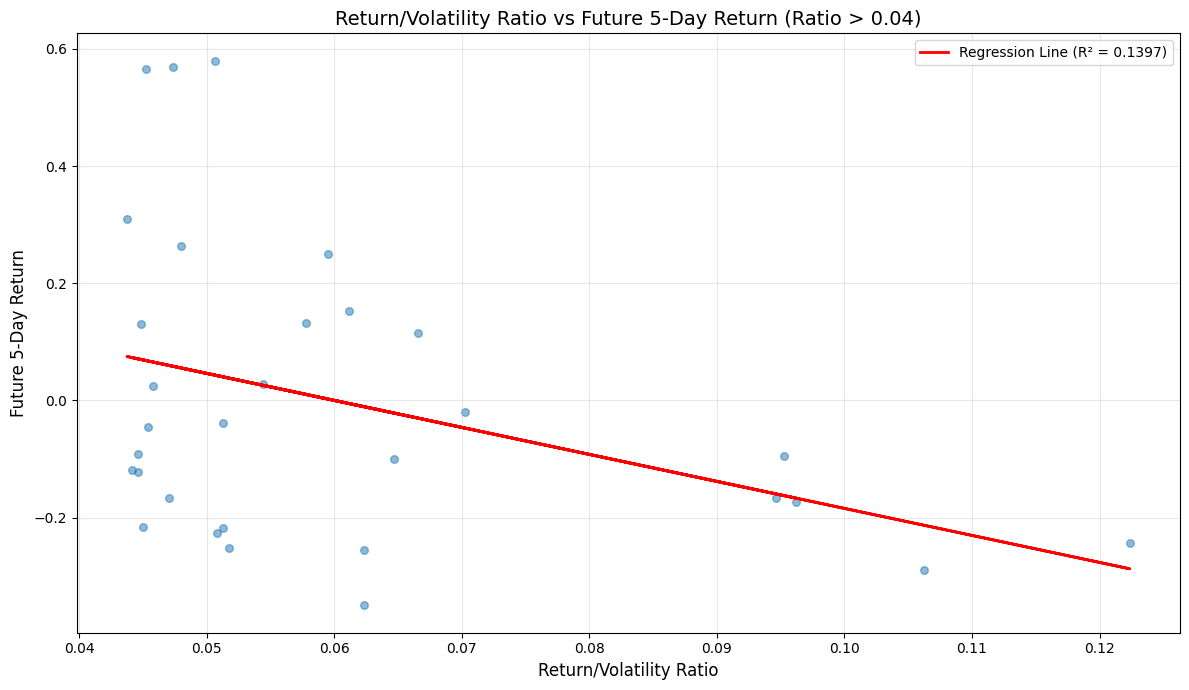

Regression Statistics (filtered for ratio > 2*std):
Number of data points: 31
Slope: -4.607503
Intercept: 0.276588
R-squared: 0.139705
P-value: 0.038331


In [475]:
# Calculate the standard deviation of return_volatility_ratio
std_ratio = df['return_volatility_ratio'].std()

# Filter for return_volatility_ratio values > 2*std
filtered_plot_df = df[df['return_volatility_ratio'] > 2 * std_ratio][['return_volatility_ratio', 'future_5d_return']].dropna()

# Calculate linear regression for filtered data
slope_filtered, intercept_filtered, r_value_filtered, p_value_filtered, std_err_filtered = stats.linregress(
    filtered_plot_df['return_volatility_ratio'], 
    filtered_plot_df['future_5d_return']
)

# Create regression line
x_line_filtered = filtered_plot_df['return_volatility_ratio']
y_line_filtered = slope_filtered * x_line_filtered + intercept_filtered

# Create scatter plot with regression line
plt.figure(figsize=(12, 7))
plt.scatter(filtered_plot_df['return_volatility_ratio'], filtered_plot_df['future_5d_return'], alpha=0.5, s=30)
plt.plot(x_line_filtered, y_line_filtered, color='red', linewidth=2, label=f'Regression Line (R² = {r_value_filtered**2:.4f})')
plt.xlabel('Return/Volatility Ratio', fontsize=12)
plt.ylabel('Future 5-Day Return', fontsize=12)
plt.title(f'Return/Volatility Ratio vs Future 5-Day Return (Ratio > {2*std_ratio:.2f})', fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

print(f"Regression Statistics (filtered for ratio > 2*std):")
print(f"Number of data points: {len(filtered_plot_df)}")
print(f"Slope: {slope_filtered:.6f}")
print(f"Intercept: {intercept_filtered:.6f}")
print(f"R-squared: {r_value_filtered**2:.6f}")
print(f"P-value: {p_value_filtered:.6f}")

In [476]:
filtered_plot_df.head(100)

,return_volatility_ratio,future_5d_return
24,0.061185,0.153258
25,0.070286,-0.020237
26,0.059548,0.250757
27,0.047396,0.568867
28,0.050632,0.579934
42,0.064702,-0.100264
43,0.054417,0.027505
44,0.051265,-0.037887
45,0.094645,-0.167201
46,0.096237,-0.173040


In [477]:
filtered_plot_df.describe()

,return_volatility_ratio,future_5d_return
count,31.000000,31.000000
mean,0.060501,-0.002172
std,0.020766,0.255980
min,0.043747,-0.349775
25%,0.045592,-0.194570
50%,0.051284,-0.090965
75%,0.063528,0.131777
max,0.122374,0.579934


In [478]:
# Find instances where close price equals local_high or global_high
df['is_local_high'] = df['close'] == df['local_high']
df['is_global_high'] = df['close'] == df['global_high']

# Create a summary DataFrame for local highs
local_high_events = df[df['is_local_high']][['open_time', 'close', 'local_high', 'future_5d_return']].copy()
local_high_events.columns = ['Date', 'Close Price', 'Local High', 'Future 5D Return']

# Create a summary DataFrame for global highs
global_high_events = df[df['is_global_high']][['open_time', 'close', 'global_high', 'future_5d_return']].copy()
global_high_events.columns = ['Date', 'Close Price', 'Global High', 'Future 5D Return']

print("LOCAL HIGH EVENTS:")
print(f"Total occurrences: {len(local_high_events)}")
print(f"Average 5-day return after local high: {local_high_events['Future 5D Return'].mean():.4f}")
print(f"Median 5-day return after local high: {local_high_events['Future 5D Return'].median():.4f}")
print("\n", local_high_events)

print("\n" + "="*80 + "\n")

print("GLOBAL HIGH EVENTS:")
print(f"Total occurrences: {len(global_high_events)}")
print(f"Average 5-day return after global high: {global_high_events['Future 5D Return'].mean():.4f}")
print(f"Median 5-day return after global high: {global_high_events['Future 5D Return'].median():.4f}")
print("\n", global_high_events)

LOCAL HIGH EVENTS:
Total occurrences: 132
Average 5-day return after local high: 0.0402
Median 5-day return after local high: -0.0202

           Date  Close Price  Local High  Future 5D Return
0   2023-01-01      0.08180     0.08180          0.235452
1   2023-01-02      0.08273     0.08273          0.234498
2   2023-01-03      0.08351     0.08351          0.226440
3   2023-01-04      0.08516     0.08516          0.093706
4   2023-01-05      0.08566     0.08566          0.078566
..         ...          ...         ...               ...
933 2025-07-22      0.07545     0.07545         -0.221604
934 2025-07-23      0.07745     0.07745         -0.220658
964 2025-08-22      0.07157     0.07157         -0.124354
985 2025-09-12      0.06884     0.06884         -0.210633
986 2025-09-13      0.06964     0.06964               NaN

[132 rows x 4 columns]


GLOBAL HIGH EVENTS:
Total occurrences: 44
Average 5-day return after global high: 0.2105
Median 5-day return after global high: 0.2062

      